# earthkit-data

本节介绍如何使用 earthkit-data 加载 GRIB2 要素场，并使用 cedarkit-maps 绘图。

## 安装

使用 conda 安装 earthkit-data

```bash
conda install -c conda-forge earthkit-data
```

## 准备

导入需要的包

In [1]:
import xarray as xr
import pandas as pd
import earthkit.data

设置绘图的数据参数，使用 CMA-MESO 2024 年 11 月 14 日 00 时次 024 时效数据。

In [2]:
system_name = "CMA-MESO"
data_type = "cma_meso_3km/grib2/orig"
start_time = pd.to_datetime("2024-11-14 00:00:00")
forecast_time = pd.to_timedelta("24h")

## 加载数据

设置 GRIB2 数据文件路径

In [3]:
file_path = '/g3/COMMONDATA/OPER/CEMC/MESO_3KM/Prod-grib/2024111400/ORIG/rmf.hgra.2024111400024.grb2'
file_path

'/g3/COMMONDATA/OPER/CEMC/MESO_3KM/Prod-grib/2024111400/ORIG/rmf.hgra.2024111400024.grb2'

> 注：可以使用 reki 库查找本地文件路径

In [4]:
from reki.data_finder import find_local_file

file_path_use_reki = find_local_file(
    data_type,
    start_time=start_time,
    forecast_time=forecast_time,
)
file_path_use_reki

PosixPath('/g3/COMMONDATA/OPER/CEMC/MESO_3KM/Prod-grib/2024111400/ORIG/rmf.hgra.2024111400024.grb2')

使用 earthkit.data 加载 2 米温度要素场。

In [5]:
ds = earthkit.data.from_source("file", file_path).sel(param="2t")
ds.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,babj,2t,heightAboveGround,2,20241114,0,24,fc,None,regular_ll


转为 `xarray.DataArray` 对象

In [6]:
t_2m_field_full_dim = ds.to_xarray()["t2m"] - 273.15
t_2m_field_full_dim

<xarray.DataArray 't2m' (time: 1, step: 1, heightAboveGround: 1,
                         latitude: 1671, longitude: 2501)> Size: 17MB
array([[[[[-19.797974 , -19.870972 , -19.942978 , ..., -20.505981 ,
           -19.986984 , -19.959976 ],
          [ -6.6259766,  -6.7809753,  -6.383972 , ..., -21.558975 ,
           -21.516983 , -20.273972 ],
          [ -6.434967 ,  -6.696991 ,  -5.9329834, ..., -21.054977 ,
           -21.480972 , -20.025986 ],
          ...,
          [ 27.062012 ,  27.073029 ,  27.068024 , ...,  27.54303  ,
            27.550018 ,  27.659027 ],
          [ 27.096008 ,  27.051025 ,  27.068024 , ...,  27.57602  ,
            27.572021 ,  27.66101  ],
          [ 27.044037 ,  27.058014 ,  27.051025 , ...,  27.549011 ,
            27.572021 ,  27.66101  ]]]]], dtype=float32)
Coordinates:
  * time               (time) datetime64[ns] 8B 2024-11-14
  * step               (step) timedelta64[ns] 8B 1 days
  * heightAboveGround  (heightAboveGround) float64 8B 2.0
  * latitude           (latitude) float64 13kB 60.1 60.07 60.04 ... 10.03 10.0
  * longitude          (longitude) float64 20kB 70.0 70.03 70.06 ... 145.0 145.0
    valid_time         (time, step) datetime64[ns] 8B ...

删掉不用的坐标维度 (time, step, heightAboveGround)

In [7]:
t_2m_field = t_2m_field_full_dim.squeeze(dim=("time", "step", "heightAboveGround"))
t_2m_field

<xarray.DataArray 't2m' (latitude: 1671, longitude: 2501)> Size: 17MB
array([[-19.797974 , -19.870972 , -19.942978 , ..., -20.505981 ,
        -19.986984 , -19.959976 ],
       [ -6.6259766,  -6.7809753,  -6.383972 , ..., -21.558975 ,
        -21.516983 , -20.273972 ],
       [ -6.434967 ,  -6.696991 ,  -5.9329834, ..., -21.054977 ,
        -21.480972 , -20.025986 ],
       ...,
       [ 27.062012 ,  27.073029 ,  27.068024 , ...,  27.54303  ,
         27.550018 ,  27.659027 ],
       [ 27.096008 ,  27.051025 ,  27.068024 , ...,  27.57602  ,
         27.572021 ,  27.66101  ],
       [ 27.044037 ,  27.058014 ,  27.051025 , ...,  27.549011 ,
         27.572021 ,  27.66101  ]], dtype=float32)
Coordinates:
    time               datetime64[ns] 8B 2024-11-14
    step               timedelta64[ns] 8B 1 days
    heightAboveGround  float64 8B 2.0
  * latitude           (latitude) float64 13kB 60.1 60.07 60.04 ... 10.03 10.0
  * longitude          (longitude) float64 20kB 70.0 70.03 70.06 ... 145.0 145.0
    valid_time         datetime64[ns] 8B ...

## 绘图

使用 cedarkit-maps 绘制 2 米温度填充图

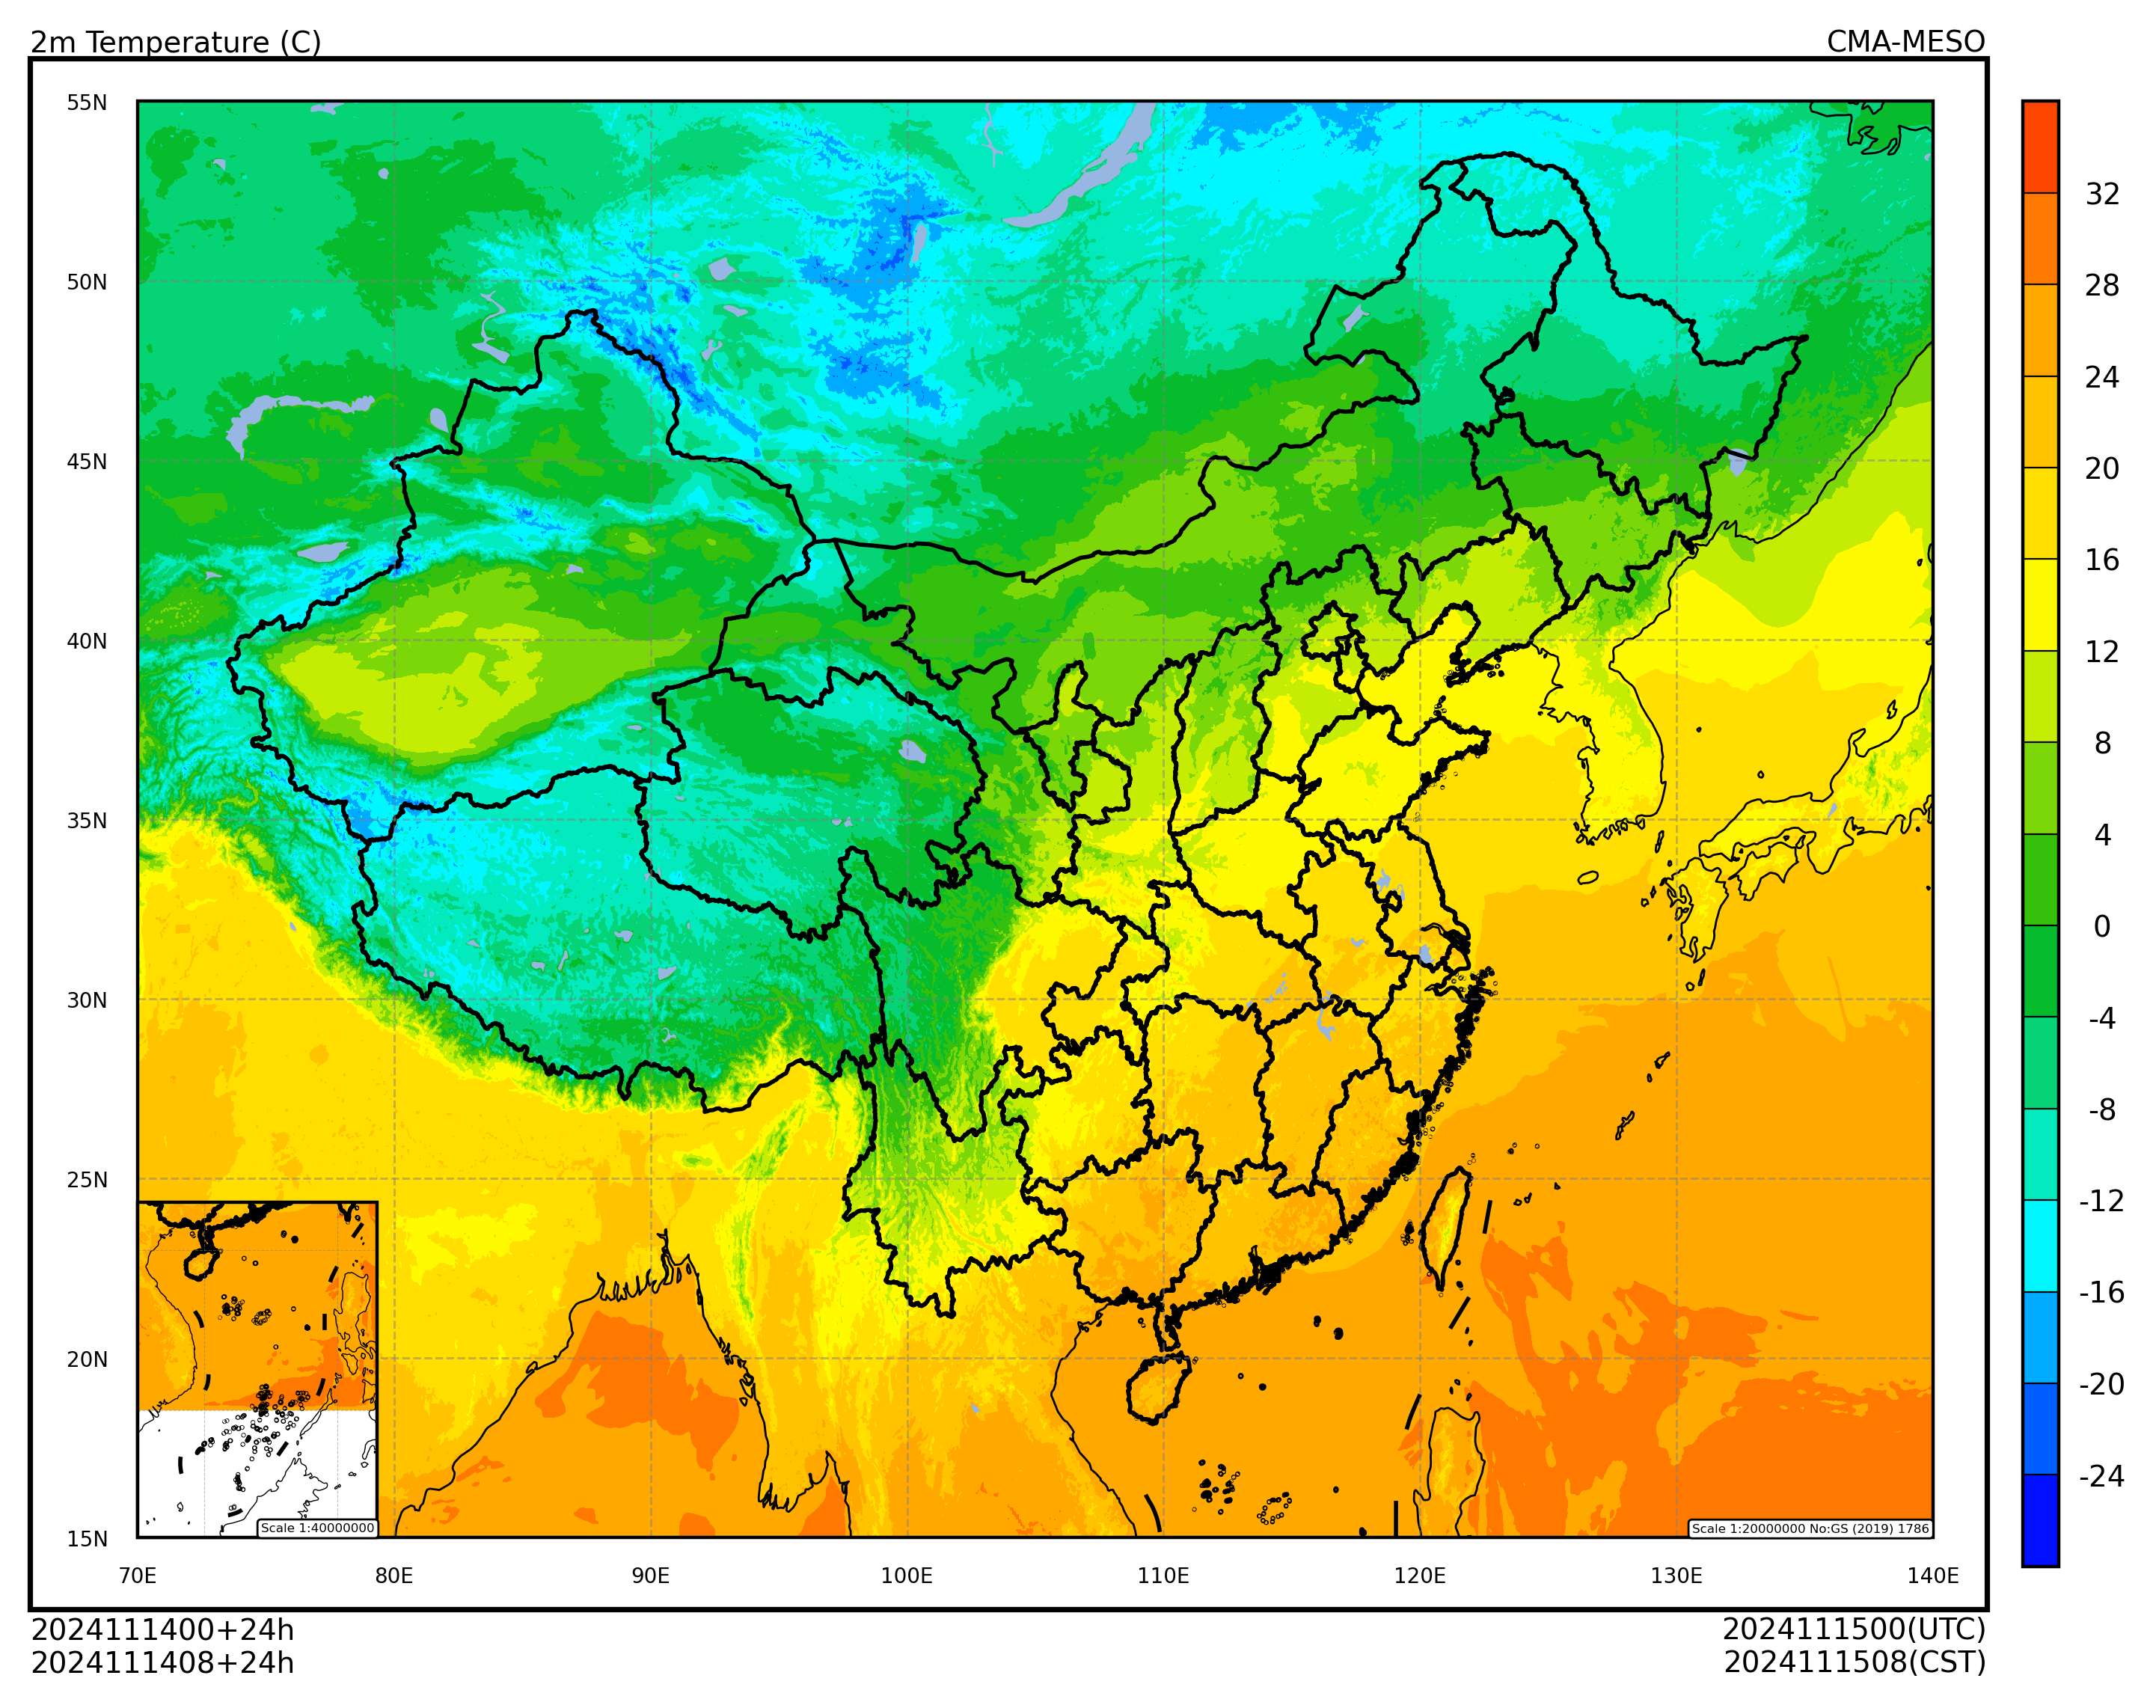

In [8]:
from cedarkit.maps.style import ContourStyle
from cedarkit.maps.chart import Panel
from cedarkit.maps.domains import EastAsiaMapTemplate
from cedarkit.maps.colormap import get_ncl_colormap

t_2m_level = [-24, -20, -16, -12, -8, -4, 0, 4, 8, 12, 16, 20, 24, 28, 32]
color_index = [2, 12, 22, 32, 42, 52, 62, 72, 82, 92, 102, 112, 122, 132, 142, 152]
t_2m_color_map = get_ncl_colormap("BlAqGrYeOrReVi200", index=color_index)
t_2m_style = ContourStyle(
    colors=t_2m_color_map,
    levels=t_2m_level,
    fill=True,
)
domain = EastAsiaMapTemplate()
panel = Panel(domain=domain)
panel.plot(t_2m_field, style=t_2m_style)
domain.set_title(
    panel=panel,
    graph_name="2m Temperature (C)",
    system_name=system_name,
    start_time=start_time,
    forecast_time=forecast_time,
)
domain.add_colorbar(panel=panel, style=t_2m_style)
panel.show()